# Track TSMC with TSM

### Libraries

In [105]:
# Import Libraries
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression  # or RandomForestRegressor etc.
from sklearn.metrics import accuracy_score  # or mean_squared_error for regression
from datetime import time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC  # SVM Classifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Functions

In [108]:
def fetch_data(ticker, timespan = '10y'):
    data_temp = yf.download(ticker, period = timespan) #get data through API
    data_temp.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data_temp.columns] #flatten the multi-index in column
    data_temp = data_temp.ffill() # remove rows with NaN
    return data_temp

In [110]:
def fetch_data_span(ticker, start_time = "2015-02-24", end_time = "2023-02-24"):
    data_temp = yf.download(ticker, start = start_time, end = end_time)
    data_temp.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in data_temp.columns] #flatten the multi-index in column
    data_temp = data_temp.ffill() # remove rows with NaN
    return data_temp

In [112]:
def get_pct_diff_lastnight(data, open_ticker, close_ticker):
    prev_Close = data[close_ticker].shift(1)  # yesterday's close
    return (data[open_ticker] - prev_Close) / prev_Close * 100  # today's open minus yesterday's close

In [114]:
def get_pct_change_lastday(data, ticker):
    pct_change = data[ticker].pct_change() * 100
    return pct_change.shift(1)

In [116]:
def get_data_lastday(data, ticker):
    return data[ticker].shift(1)

In [118]:
# from GPT
def get_volume_lastday(data, ticker):
    vol_lastday = data[ticker].shift(1)
    scaler = StandardScaler()
    scaled = scaler.fit_transform(vol_lastday.values.reshape(-1, 1))
    return pd.Series(scaled.flatten(), index=vol_lastday.index)

In [120]:
def get_diff_to_avg_lastday(data, ticker, timespan = 5):
    avg = data[ticker].rolling(timespan).mean()
    diff_to_avg = data[ticker] - avg
    return diff_to_avg.shift(1)

In [122]:
def get_diff_label(data, openticker, closeticker, threshold = 0.004, timespan = 0):
    df_temp = pd.DataFrame()
    df_temp['diff'] = (data[closeticker].shift(timespan) - data[openticker]) / data[openticker]
    conditions = [
    df_temp['diff'] > threshold,
    df_temp['diff'].between(- threshold, threshold),
    df_temp['diff'] < - threshold
    ]
    choices = [1, 0, -1]
    return pd.Series(np.select(conditions, choices), index=data.index)

## Introduce Data from: 2330, S&P500, VIX, SOX, TSM

In [154]:
# fetch data
data = pd.DataFrame()
# data = fetch_data(ticker = ['^GSPC', '2330.TW', 'TSM', '^VIX', '^SOX'], timespan = '5y')
data = fetch_data_span(ticker = ['2330.TW', 'TSM'], start_time = "2015-02-24", end_time = "2023-02-24")

# print(data.head(), '\n\n============================')

# data manipulation to get features
df = pd.DataFrame()
# df['2330_diff_lastnight'] = get_pct_diff_lastnight(data, 'Open_2330.TW', 'Close_2330.TW')
# df['2330_diff_to_5d_avg_lastday'] = get_diff_to_avg_lastday(data, 'Close_2330.TW') #doesn't work with function

# df['SP500_change_lastday'] = get_pct_change_lastday(data, 'Close_^GSPC')
# df['SP500_vol_lastday'] = get_volume_lastday(data, 'Volume_^GSPC')
# df['SP500_diff_to_5d_avg_lastday'] = get_diff_to_avg_lastday(data, 'Close_^GSPC')

df['TSM_change_lastday'] = get_pct_change_lastday(data, 'Close_TSM')
df['TSM_vol_lastday'] = get_volume_lastday(data, 'Volume_TSM')
df['TSM_diff_to_5d_avg_lastday'] = get_diff_to_avg_lastday(data, 'Close_TSM')
df['TSM_close_lastday'] = get_data_lastday(data, 'Close_TSM')


# df['VIX_change_lastday'] = get_pct_change_lastday(data, 'Close_^VIX')
# df['VIX_lastday'] = get_data_lastday(data, 'Close_^VIX')

# df['SOX_change_lastday'] = get_pct_change_lastday(data, 'Close_^SOX')
# df['SOX_lastday'] = get_data_lastday(data, 'Close_^SOX')


print(df.head(10))


[*********************100%***********************]  2 of 2 completed

            TSM_change_lastday  TSM_vol_lastday  TSM_diff_to_5d_avg_lastday  \
Date                                                                          
2015-02-24                 NaN              NaN                         NaN   
2015-02-25                 NaN         1.444576                         NaN   
2015-02-26            0.000000         0.277366                         NaN   
2015-02-27           -1.437683        -0.312081                         NaN   
2015-03-02           -0.607784        -0.111556                         NaN   
2015-03-03            0.407643        -0.418880                   -0.116059   
2015-03-04           -0.527798        -0.333807                   -0.132636   
2015-03-05           -0.693849         0.072442                   -0.153733   
2015-03-06            0.534306        -0.460732                   -0.022607   
2015-03-09           -1.512718        -0.567552                   -0.235133   

            TSM_close_lastday  
Date               

In [156]:
#get label
# df['label_1d'] = get_diff_label(data, openticker = 'Open_2330.TW', closeticker = 'Close_2330.TW')
df['label'] = data['Close_2330.TW']
print(df.head())

            TSM_change_lastday  TSM_vol_lastday  TSM_diff_to_5d_avg_lastday  \
Date                                                                          
2015-02-24                 NaN              NaN                         NaN   
2015-02-25                 NaN         1.444576                         NaN   
2015-02-26            0.000000         0.277366                         NaN   
2015-02-27           -1.437683        -0.312081                         NaN   
2015-03-02           -0.607784        -0.111556                         NaN   

            TSM_close_lastday       label  
Date                                       
2015-02-24                NaN  113.844566  
2015-02-25          18.870462  116.483353  
2015-02-26          18.870462  113.467598  
2015-02-27          18.599165  113.467598  
2015-03-02          18.486122  112.336685  


## Assign Labels Features
### (S&P lastnight, vol; 2330 diff overnight; VIX lastnight; TSM lasnight changes, vol; SOX lastnight changes

In [159]:
# Clean the df
df_clean = df.dropna()

# Split your dataset first
X = df_clean.drop(columns = ['label'])  # features
y = df_clean['label']  # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X_train:", len(X_train), "y_train:", len(y_train))
print("X_test:", len(X_test), "y_test:", len(y_test))
print('=============================')

# Scale features (recommended for SVM and others)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)
# print("X_train:", len(X_train), "y_train:", len(y_train))
# print("X_test:", len(X_test), "y_test:", len(y_test))

X_train: 1656 y_train: 1656
X_test: 415 y_test: 415


## Check correlation between features

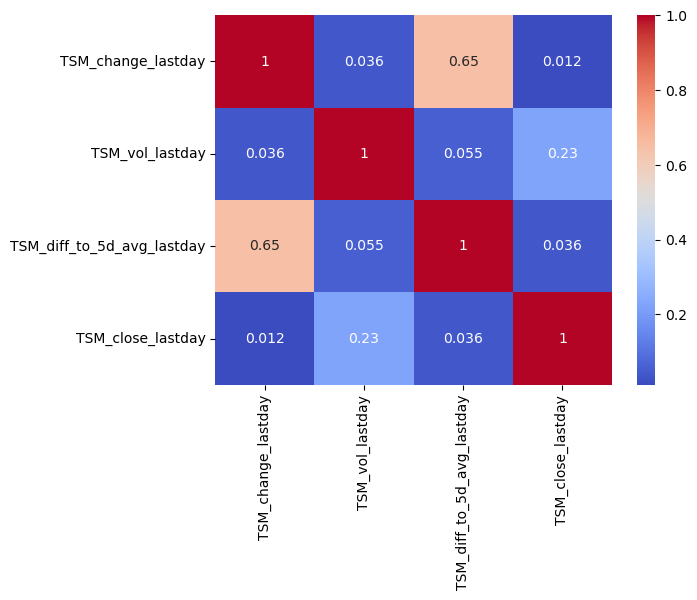

In [133]:
corr = X.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()

## Train the Model with LinearRegression

In [161]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## Evaluate the Result

In [164]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}')

MAE: 12.594, RMSE: 341.853, R²: 0.987


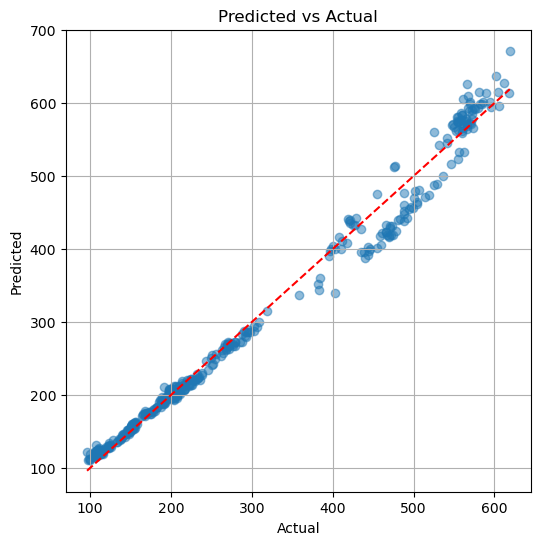

In [166]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # perfect prediction line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')
plt.grid(True)
plt.show()

# Test run on seperate data

In [169]:
test_run_data = pd.DataFrame()
test_run_data = fetch_data_span(ticker = ['2330.TW', 'TSM'], start_time = "2023-02-25", end_time = "2025-02-25")

test_run_df = pd.DataFrame()
test_run_df['TSM_change_lastday'] = get_pct_change_lastday(test_run_data, 'Close_TSM')
test_run_df['TSM_vol_lastday'] = get_volume_lastday(test_run_data, 'Volume_TSM')
test_run_df['TSM_diff_to_5d_avg_lastday'] = get_diff_to_avg_lastday(test_run_data, 'Close_TSM')
test_run_df['TSM_close_lastday'] = get_data_lastday(test_run_data, 'Close_TSM')
test_run_df['label'] = test_run_data['Close_2330.TW']
test_run_df_clean = test_run_df.dropna()

print(test_run_df_clean.head())
print("X_test_run:", len(X_test_run), "y_test_run_pred:", len(y_test_run_pred))

X_test_run = test_run_df_clean.drop(columns = ['label'])
y_test_run_pred = model.predict(X_test_run)
y_test_run = test_run_df_clean['label']

print("X_test_run:", len(X_test_run), "y_test_run_pred:", len(y_test_run_pred))


mae = mean_absolute_error(y_test_run, y_test_run_pred)
rmse = mean_squared_error(y_test_run, y_test_run_pred)
r2 = r2_score(y_test_run, y_test_run_pred)

print(f'MAE: {mae:.3f}, RMSE: {rmse:.3f}, R²: {r2:.3f}')

[*********************100%***********************]  2 of 2 completed

            TSM_change_lastday  TSM_vol_lastday  TSM_diff_to_5d_avg_lastday  \
Date                                                                          
2023-03-06            0.853622        -0.279297                    1.414391   
2023-03-07           -0.233861        -0.396453                    0.772722   
2023-03-08           -0.814923        -0.555343                   -0.273633   
2023-03-09            2.228469        -0.548464                    1.169667   
2023-03-10           -2.146858        -0.344143                   -0.680219   

            TSM_close_lastday       label  
Date                                       
2023-03-06          86.511520  501.753265  
2023-03-07          86.309204  504.642487  
2023-03-08          85.605850  501.753265  
2023-03-09          87.513550  502.716400  
2023-03-10          85.634758  494.048859  
X_test_run: 514 y_test_run_pred: 514
X_test_run: 514 y_test_run_pred: 514
MAE: 54.103, RMSE: 3321.477, R²: 0.932


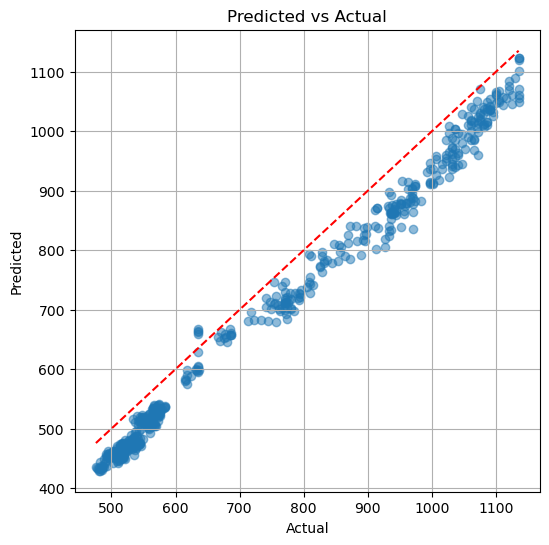

In [171]:
plt.figure(figsize=(6,6))
plt.scatter(y_test_run, y_test_run_pred, alpha=0.5)
plt.plot([y_test_run.min(), y_test_run.max()], [y_test_run.min(), y_test_run.max()], 'r--')  # perfect prediction line
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')
plt.grid(True)
plt.show()

## Feature Importance

In [100]:
importances = model.feature_importances_
print(type(importances))
print(importances)

AttributeError: 'LinearRegression' object has no attribute 'feature_importances_'

## Try finding Best-performing Hyper-perimeter

In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'poly', 'linear'],
    'gamma': ['scale', 'auto', 0.01, 0.001]
}

grid = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best score:", grid.best_score_)

## Potential Idea for features

instead of 2330, use different stocks/ indexs

2330/ TSM should converge

more diff to avg(5d, w, m, y, 10y) data as features?

instead of indexes, use higher/ more direct related stocks

create test for real return
